# HCI Week 3 - Coronagraphs Part I
*Matthew Kenworthy // Leiden Observatory*

Today we cover encircled energy plots and simulate a simple Lyot coronagraph. Read through the functions defined in the block below, as they may help with the exercises.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')


def displC(c,trim=0):
    # displC - display a Complex number c as four plots
    #          as a (Real, Imaginary) pair and as
    #          an Amplitude, Phase plot
    #          optionally cut out the central square with size trim by trim pixels   
    c2 = np.copy(c)
    if (trim>0): # if the user specifies a trim value, cut out the centre of the image
        (nx,ny) = c.shape
        dx = np.array((nx-trim) / 2).astype(int)
        dy = np.array((nx-trim) / 2).astype(int)
        c2 = c[dx:dx+trim,dy:dy+trim]
        
    # set up the plot panels
    fig=plt.figure(figsize=(10,8))
    axre = fig.add_subplot(221)
    axim = fig.add_subplot(222)
    axamp = fig.add_subplot(223)
    axpha = fig.add_subplot(224)
    # plot out the panels
    im = axre.imshow(c2.real)
    im = axim.imshow(c2.imag)
    im = axamp.imshow(np.abs(c2))
    im = axpha.imshow(np.angle(c2))
    
    axre.set_title('Real')
    axim.set_title('Imag')
    axamp.set_title('Amplitude')
    axpha.set_title('Phase')
    plt.show()

def padcplx(c,pad=5):
    # padcplx - puts a Complex array in the centre of a zero-filled Complex array
    #           pad defines the padding multiplier for the output array
    (nx, ny) = c.shape
    bignx = nx*pad
    bigny = ny*pad
    big_c = np.zeros((bignx,bigny),dtype=complex)

    dx = np.array((nx * (pad-1)) / 2).astype(int)
    dy = np.array((ny * (pad-1)) / 2).astype(int)

    big_c[dx:dx+nx,dy:dy+ny] = c
    return(big_c)

def FFT(c,pad=5):
    """FFT - carry out the complex Fourier transform (with optional padding)
    and return the FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfA = fftshift(fft2(ifftshift(padcplx(c,pad))))
    return psfA

def IFFT(c,pad=5):
    """FFT - carry out the complex Fourier transform (with optional padding)
    and return the FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfA = fftshift(ifft2(ifftshift(padcplx(c,pad))))
    return psfA

def circle_mask(im, xc, yc, rcirc):
        ny, nx = im.shape
        y,x = np.mgrid[0:nx,0:ny]
        r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
        return ( (r < rcirc))
    

def r_theta(im, xc, yc):
    # returns the radius rr and the angle phi for point (xc,yc)
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

def phi_ramp(im, npx, npy):
    ny, nx = im.shape
    ly = np.linspace(-0.5, 0.5, ny) * np.pi * npy * 2
    lx = np.linspace(-0.5, 0.5, nx) * np.pi * npx * 2
    
    x, y = np.meshgrid(lx, ly) 
    return(x+y)

def logit(im, minlog=-6):
    # logit - takes the log10 of an image and rounds up tiny logs to minlog so that displC()
    #         works better
    imout = np.copy(im)
    logimout = np.log10(imout)
    logimout[(logimout<minlog)] = minlog
    return(logimout)

def zoom(im,x,y,bb):
    #returns a square 2D image cut out from im centered on location (x,y) and with half-width bb
    return(im[y-bb:y+bb,x-bb:x+bb])

** Q1 (2 points):** The first stage is to make a telescope pupil with a diameter of 101 pixels. The pupil is circular with no central obscuration, and the circle must touch all 4 sides of the square. Make this a complex amplitude pupil with an amplitude per pixel of 1 and zero phase, and call this telescope pupil `A`.

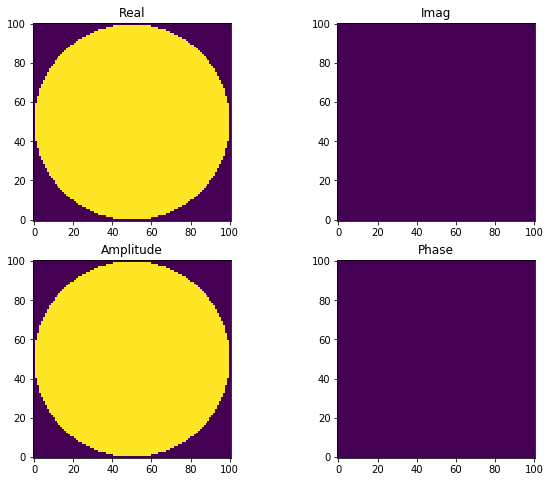

In [2]:
#Circular pupil with 101 pixels diameter

dtel = 101 # pixels
nsamp = 7

im = np.zeros((dtel,dtel))
#im = np.zeros((dtel,dtel),dtype=complex)
#im[:,:] = 0+1j
xc    = (dtel-1.) / 2.
yc    = (dtel-1.) / 2.
rcirc = (dtel-1.) / 2.

Pupil = circle_mask(im, xc, yc, rcirc)

displC(Pupil)

A = padcplx(Pupil, nsamp) #Telescope pupil

## Conserving flux from Pupil to Focal Planes
We should normalise the **intensity** of the telescope pupil to a value of 100.0 intensity units. 

**Q2 (2 points):** Write a subroutine to calculate the summed intensity of a complex amplitude input image and have it return a real number. Call this routine `Isum()` and use it to normalise the telescope pupil amplitude `A`. Show that you have done the normalisation correctly by showing that `Isum(A) = 100.0` 

In [3]:
#Summed intensity of a complex amplitude input image

def Isum(im):
    I   = (np.abs(im))**2
    Sum = np.sum(I)
    return Sum
print('The summed intensity is: %4.1f'%Isum(A))

Norm_factor = 100.0 #Normalise to a value of 100.0 intensity units
A_1 = (A / np.sqrt(Isum(A)))*np.sqrt(Norm_factor)

print('Normalised intensity: %3.1f'%Isum(A_1))


The summed intensity is: 7825.0
Normalised intensity: 100.0


** Q3 (2 points):** Calculate the Amplitude Spread Function (ASF) for this telescope pupil with a sampling of 7 (use a variable `nsamp` to hold this, as you may want to easily change this value later on), and call this new complex amplitude `B`. Print out the `Isum` of `B`. Since energy is conserved, you should get `Isum(B) = 100.0` - but you don't. Instead it's a much higher number. There is a normalisation factor that will get you back to `100.0`, and you can calculate it from your input `A`. 

**HINT:** it's related to how the FFT routine works, and involves a very simple quantity associated with all `numpy` arrays. Look at the `numpy` documentation for all properties associated with a defined numpy variable, and also look at what the scaling factor appears to be.

Show that you have normalised B correctly by making `Bn` be the correctly normalised version of `B` and show `Isum(Bn) = 100.0` 


In [4]:
B = FFT(A_1, pad = 1) #ASF for the telescope pupil
print('The summed intensity for B is: %.2f'%Isum(B))

#The normalization factor is given by: 100*[dtel*nsamp]^2
#where 100 is required to obtain the 100.0 luminosity units, 
#dtel is the size in pixels defined for our pupil, 
#nsamp is defined for the fourier transform. 

#A is already normalized so we don't need the 100.0 pre-factor nor the squared value. 
#The scaling factor is the number of pixels of the array A

NORM = (dtel*nsamp)

Bn = B / NORM
print('The normalised summed intensity: %3.1f'%Isum(Bn))

The summed intensity for B is: 49984900.00
The normalised summed intensity: 100.0


## Calculating encircled energy as a function of radius
The energy of the star (or planet) is spread out over the focal plane in an Airy disk of radius $1.22 \lambda / D$, where our sampling `nsampl` is equal to $\lambda / D$.

** Q4 (4 points):** Write a routine  `ee(im, xap, yap, r_ap)` to calculate the fraction of encircled energy within a circular aperture of radius `r_ap` centered at `(xap, yap)` in a complex image `im`.

To improve efficiency, make it so that `r_ap` can be a numpy array of radii, and use a `for` loop with `enumerate()` to return a numpy array of encircled energy values. 

**HINT** Look at the routine `r_theta()` at the start of the Practicum

In [5]:
#Fraction of encircled energy within a circular aperture of radius r_ap 
#centered at  (xc, yc) in a complex image im.

def ee(im, xc, yc, r_ap):
    (rr, phi) = r_theta(im, xc, yc) #Returns the radius rr and angle phi for point (xc, yc)
    Intensity = Isum(im)            #This corresponds to the total energy of the image
    
    Encircled_Energy = []
    for i,b in enumerate(r_ap):
        Circle = (rr < b)
        Energy = Isum(Circle*im) / Intensity #Energy inside the circle defined above
        Encircled_Energy.append(Energy)
        
#     for radius in r_ap:
#         Circle = (rr < radius)
#         Energy = Isum(Circle*im) / Intensity #Energy inside the circle defined above
#         Encircled_Energy.append(Energy)
        
    return Encircled_Energy   

** Q5 (6 points):** Plot out the encircled energy versus increasing aperture radii for the PSF in `B`.

Starting with a radius of 1 pixel, go in steps of 1 pixel out to $10 \lambda/D$. Label the x-axis of the plot in unit of $\lambda/D$. (Yes, I know I'm changing units on you!)

Plot a vertical line at a radius of $1.22 \lambda/D$.

What is the *fraction* of the total energy enclosed within a radius of $1.22 \lambda/D$? 

**Sanity check** what should the EE be for very large radii?

The fraction at r = 1.22L/D is: 0.800180


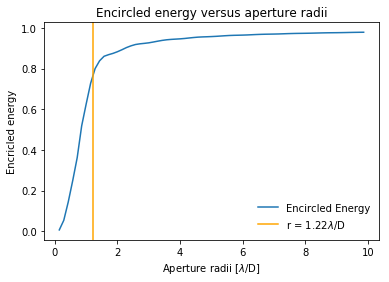

In [6]:
#Encircled energy versus increasing aperture radii
Radii  = np.arange(1, 10 * nsamp)              #From 1 to 10 with nsamp = lambda/D
Center = (dtel - 1.)*nsamp / 2.
Encircled_energy = ee(B, Center, Center, Radii)

plt.plot(Radii/nsamp , Encircled_energy, label = 'Encircled Energy')       #Radii in units of Lambda/D
plt.title('Encircled energy versus aperture radii')
plt.xlabel(r'Aperture radii [$\lambda$/D]')
plt.ylabel('Encricled energy')
plt.axvline(1.22, color = 'orange', label = r'r = 1.22$\lambda$/D')
plt.legend(frameon = False, loc = 'best')

# Fraction = Encircled_energy[int(1.22 * nsamp)]
Fraction = Encircled_energy[int(1.22 * nsamp)]
print('The fraction at r = 1.22L/D is: %f'%Fraction) # The answer is roughly 83.8%.

#The EE at very large radii should approach to 1.0 which mean the 100% of the light 
#is within that given radius.

## Coronagraph Simulator

Here is a simple optical layout of a telescope, coronagraph, and science imaging camera. The figure is taken from [Sivaramakrishnan and Oppenheimer (2006)](http://adsabs.harvard.edu/abs/2006ApJ...647..620S).

<img src="coronagraph.png">


  * A is the telescope entrance pupil
  * B is the first focal plane
  * $m(k)$ is the focal plane coronagraphic mask
  * C is the masked first focal plane
  * D is the Lyot pupil plane
  * $N(x)$ is the Lyot pupil plane coronagraphic mask
  * E is the masked Lyot plane
  * F is the final focal plane
  
Many types of coronagraph can be specified with $m(k)$ and $N(x)$, resulting in attenuation for on-axis sources whilst letting as much light from a nearby companion through.

The axis of the coronagraph is at  the central pixel `xcen,ycen` of `B`, `C` and `F`, and we will refer to this pixel as being at the origin, i.e. $(x,y)=(0,0)$ for the central pixel.

This week we will make a Lyot coronagraph and compare its efficiency at transmitting and rejecting light compared to direct imaging. We define the function `coro()` which produces the final science camera focal plane image `F` and all the intermediate planes. 

In [7]:
def coro(A, m, N, nsamp):
    B = FFT(A,nsamp)
    C = m * B
    D = IFFT(C,1)
    E = N * D
    F = FFT(E,1)

    return(B,C,D,E,F)

First things first - let's see that `coro()` works by putting in two transmissive masks for `m` and `N`. Remember that both masks will have to be padded to the same size as `B` in order for `coro()` to work. 

** Q6 (6 points):** Use the telescope pupil `A` with `Isum = 100.0` and `nsamp=7`, and show that the `Isum` of `B`,`C`,`D`,`E` and `F` are all `100.0` (or very close to this, depending on numerical precision). Remember that you will have to correct the intensities according to the relation you found out earlier in the notebook.

In [8]:
Coro_mask  = np.ones(A_1.shape)                       #m mask
Lyot_pupil = np.ones(A_1.shape)                       #N mask 
(B, C, D, E, F) = coro(A_1, Coro_mask, Lyot_pupil, 1) #Evaluating coro

B = (B / np.sqrt(Isum(B)))*np.sqrt(Norm_factor)
C = (C / np.sqrt(Isum(C)))*np.sqrt(Norm_factor)
D = (D / np.sqrt(Isum(D)))*np.sqrt(Norm_factor)     #Normalizing 
E = (E / np.sqrt(Isum(E)))*np.sqrt(Norm_factor)
F = (F / np.sqrt(Isum(F)))*np.sqrt(Norm_factor)

print('The summed intensity of B is: %3.1f'%Isum(B))
print('The summed intensity of C is: %3.1f'%Isum(C))
print('The summed intensity of D is: %3.1f'%Isum(D))
print('The summed intensity of E is: %3.1f'%Isum(E))
print('The summed intensity of F is: %3.1f'%Isum(F))

The summed intensity of B is: 100.0
The summed intensity of C is: 100.0
The summed intensity of D is: 100.0
The summed intensity of E is: 100.0
The summed intensity of F is: 100.0


We put the star we wish to block on the central axis of the coronagraph - this is done already with telescope pupil `A`, normalised to `Isum(A) = 100.0`.

** Q7 (2 points):** Make a copy of `A` using `np.copy()` and call it `A_star`, and use `coro()` to generate the PSF at the first focal plane and call it `B_star`. 

In [9]:
# Creating a copy of A_1 and generating the PSF at the first focal plane B
A_star = A_1.copy()
B_star, C_star, D_star, E_star, F_star = coro(A_star, Coro_mask, Lyot_pupil, 1)

We can now make a planet that is 10000 times fainter **in energy** than the star, and move it off the axis of the coronagraph by adding a tilt in phase across the telescope pupil.

** Q8 (6 points):** Make a planet image that is $5 \lambda / D$ along the +ve x-axis by making a copy of the star's telescope pupil, and adding a suitable ramp of phase to the telescope pupil - call this `A_planet` and using `coro()` and `displC(B_planet, 151)` show that the resultant PSF of the planet in the first focal plane `B` is moved off of the central axis of the coronagraph.

**HINT** Go look at `phi_ramp()` and see what it's doing.

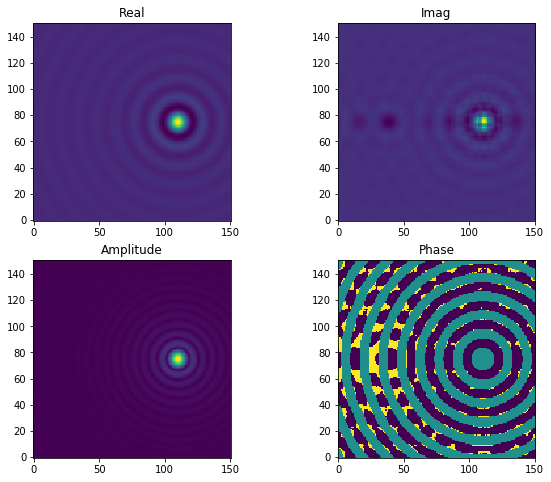

In [10]:
# Creating the planet at 5L/D

Norm_planet = Norm_factor / 10000.  #Makes the planet 10000 times fainter than the star.

phase    = phi_ramp(A_star, 5*nsamp, 0)
Ramp     = A_star*np.exp(1j * phase)
A_planet = padcplx(Ramp, pad = 1)                                      #Applying the ramp to the planet
A_planet = A_planet / np.sqrt(Isum(A_planet)) * np.sqrt(Norm_planet)   #Normalizing the planet 'aperture'

B_planet, C_planet, D_planet, E_planet, F_planet = coro(A_planet, Coro_mask, Lyot_pupil, 1) 
#Using coro on the planet

displC(B_planet, trim = 151)

The diffracted light from the star forms a **halo** of light in the science camera focal plane `F`. We can compare the halo of light from the star with the flux from the planet at the $5 \lambda / D$ location. We will do this by plotting the star's PSF and planet PSF and comparing relative fluxes.

** Q9 (4 points):** Write a routine `xaxis_energy(im,xr)` that takes a complex image `im`, cuts out the line of pixels from -xr to +xr across the middle of the image (equivalent to $y=0$) and returns the *energy per pixel* along that line.

In [11]:
#Function which takes a complex image and computes the energy per pixel along a line

def xaxis_energy(im, xr):    
    Line = im[int(xc*nsamp) , int( (xc*nsamp)-xr ): int( (xc*nsamp)+xr+1)] #Line between -xr to +xr
    return np.absolute(Line)**2

We compare the **direct imaging** case first by looking at the PSFs of the star and the planet in the `B` values.

The peak of the PSF of the star is in the middle of the array `B_star`. 

** Q10 (6 points):** Plot out the `log10` energy of the PSF centered on the axis of the coronagraph along the x axis from -10 to + 10 $\lambda/D$ . The x-axis should be labelled in units of $\lambda/D$.

You should see that the planet's peak flux is slightly below the stellar halo at $5 \lambda/D$.

Overplot the planet's PSF on the same graph. the Python notebook automatically does this if you run two or more `plt.plot()` commands within the same code cell.

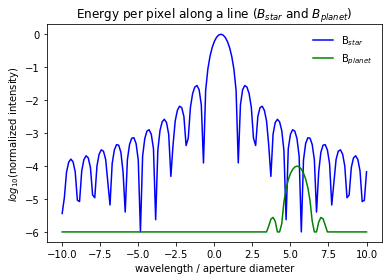

In [12]:
#Planet and Star PSF.

B_planet    = B_planet / np.sqrt(Isum(B_planet)) * np.sqrt(Norm_planet) #Normalizing B_satr and B_planet to compare
B_star      = B_star / np.sqrt(Isum(B_star)) * np.sqrt(Norm_factor)

# Energy_line = xaxis_energy(B_planet, 10*nsamp) #energy along a line for the planet
# plt.figure()
# plt.plot(Energy_line, c  = 'g', linewidth = 1.5, label = r'B$_{planet}$')
# plt.title(r'Energy per pixel along a line ($B_{planet}$)')
# plt.xlabel('pixel value')
# plt.ylabel('Energy along the central line')
# plt.legend(frameon = False, loc = 'best')

Center = (np.arange(10 * nsamp * 2 + 1) - 10 * nsamp) / nsamp #New axis center

plt.figure()
plt.plot( Center, logit(xaxis_energy(B_star, 10 * nsamp)), c  = 'b', linewidth = 1.5, label = r'B$_{star}$' )
plt.plot( Center, logit(xaxis_energy(B_planet, 10 * nsamp)), c  = 'g', linewidth = 1.5, label = r'B$_{planet}$' )
plt.title(r'Energy per pixel along a line ($B_{star}$ and $B_{planet}$)')
plt.xlabel('wavelength / aperture diameter')
plt.ylabel(r'$log_{10}$(normalized intensity)')
plt.legend(frameon = False, loc = 'best')
#Energy of the PSF centered on the axis of the coronagraph along the x axis from -10L/D to +10L/D
#for B_star and B_planet both normalised.

Finally, let's put in a classical Lyot coronagraph!

A classical Lyot coronagraph consists of a hard-edged occulter in the first focal plane, followed by a Lyot stop in the second pupil (the Lyot) plane.

** Q11 (4 points):** Make a hard edged mask `m_lyot` that has a radius of $3 \lambda/D$. It should have a transmission of 0 within this radius, and a transmission of 1 outside this radius. Assume there is no phase change with light passing through the mask.

Display the effect of the mask `m_lyot` on the planet's PSF `B_planet` by calculating `C_planet` and then use `displC(x, 151)`


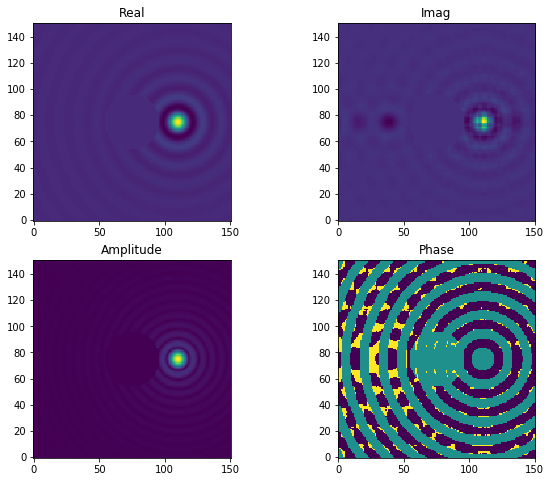

In [13]:
#A hard edged mask M_lyot of radius of 3λ/D. Transmission is 0 within this radius and 1 out of it. 

M_lyot = circle_mask(np.zeros((dtel, dtel)), xc, yc, 3 * nsamp)
M_lyot = (padcplx(M_lyot, pad = nsamp) == 0)
#displC(M_lyot)

B_planet, C_planet, D_planet, E_planet, F_planet = coro(A_planet, M_lyot, Lyot_pupil, 1)
displC(C_planet,151)

Make the Lyot stop `N_lyot` so that it blocks all light outside 0.8 times the diameter of the pupil at location `D` in the coronagraph, and run the coronagraph simulator for both the star and the planet.

** Q12 (4 points):** Make the same logarithmic energy plots with the same x-axis range for the final science camera plane `F_star` and `F_planet`. Which object is brighter at $5 \lambda/ D$ now?

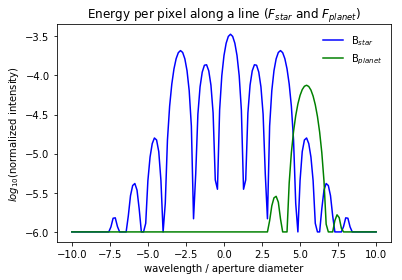

In [14]:
#Lyot stop N_lyot. it blocks all light outside 0.8 times 
#the diameter of the pupil at location D in the coronagraph
N_lyot = padcplx(circle_mask(np.zeros((dtel, dtel)), xc, yc, 0.8 *xc), pad = nsamp)

B_star, C_star, D_star, E_star, F_star = coro(A_star, M_lyot, N_lyot, 1)
B_planet, C_planet, D_planet, E_planet, F_planet = coro(A_planet, M_lyot, N_lyot, 1)

F_planet    = F_planet / np.sqrt(Isum(F_planet)) * np.sqrt(Norm_planet) #Normalizing F_star and F_planet to compare
F_star      = F_star / (dtel * nsamp)

plt.figure()
plt.plot( Center, logit(xaxis_energy(F_star, 10 * nsamp)), c  = 'b', linewidth = 1.5, label = r'B$_{star}$' )
plt.plot( Center, logit(xaxis_energy(F_planet, 10 * nsamp)), c  = 'g', linewidth = 1.5, label = r'B$_{planet}$' )
plt.title(r'Energy per pixel along a line ($F_{star}$ and $F_{planet}$)')
plt.xlabel('wavelength / aperture diameter')
plt.ylabel(r'$log_{10}$(normalized intensity)')
plt.legend(frameon = False, loc = 'best')
#Energy of the PSF centered on the axis of the coronagraph along the x axis from -10L/D to +10L/D
#for B_star and B_planet both normalised.

#In this case at 5λ/D the planet is brighter than the star. 

** Q13 (2 points):** Overplot `B_star` and `F_star` on the same plot. Estimate by eye the suppression factor of the coronagraph by looking at the peak of the PSFs.

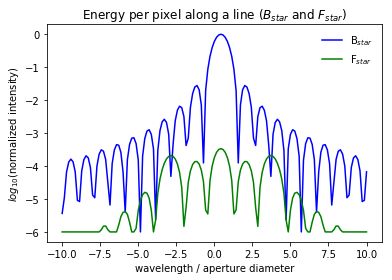

In [15]:
B_star = B_star / (dtel * nsamp)

plt.plot( Center, logit(xaxis_energy(B_star, 10 * nsamp)), c  = 'b', linewidth = 1.5, label = r'B$_{star}$')
plt.plot( Center, logit(xaxis_energy(F_star, 10 * nsamp)), c  = 'g', linewidth = 1.5, label = r'F$_{star}$')
plt.title(r'Energy per pixel along a line ($B_{star}$ and $F_{star}$)')
plt.xlabel('wavelength / aperture diameter')
plt.ylabel(r'$log_{10}$(normalized intensity)')
plt.legend(frameon = False, loc = 'best')

#The suppression factor is ~ log10(-3.5) (3.5 orders of magnitude) for the central peak of the star. 

** Q14 (2 points): ** Overplot `B_planet` and `F_planet`. What has happened to the Airy rings? Why?


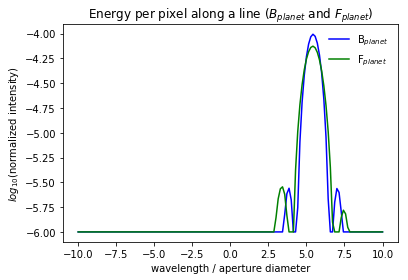

In [16]:
#After applying the Lyot mask to decrease the star's brightness the planet Airy rings change. 
#They are also diminished in brightness but not so dramatically as the star. They also are no longer
#symmetric. This is due to the fact that the mask is closer to one side of the first Airy ring than the other, 
#affecting in different ways the intensity. 

B_planet = B_planet / np.sqrt(Isum(B_planet)) * np.sqrt(Norm_planet)

plt.plot( Center, logit(xaxis_energy(B_planet, 10 * nsamp)), c  = 'b', linewidth = 1.5, label = r'B$_{planet}$')
plt.plot( Center, logit(xaxis_energy(F_planet, 10 * nsamp)), c  = 'g', linewidth = 1.5, label = r'F$_{planet}$')
plt.title(r'Energy per pixel along a line ($B_{planet}$ and $F_{planet}$)')
plt.xlabel('wavelength / aperture diameter')
plt.ylabel(r'$log_{10}$(normalized intensity)')
plt.legend(frameon = False, loc = 'best')

The star and the planet are incoherent sources with respect to each other, and so the image on the sky is the sum of their separate intensities.

** Q15 (2 points):** Make an intensity image of the star and planet before the coronagraph, and display it with `displC(logit(x),151)`.

Make an image after the coronagraph as well. You should be able to see the planet.

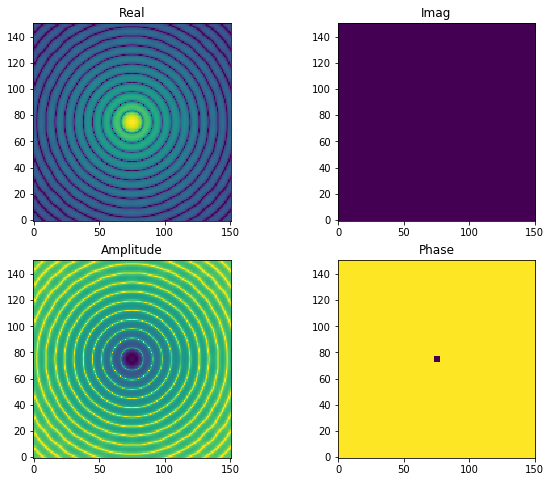

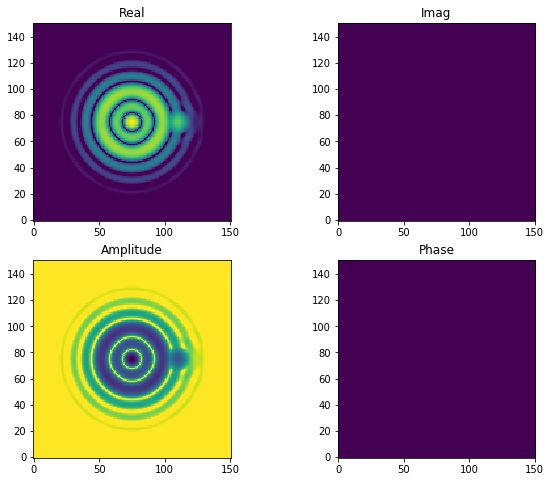

In [17]:
# Before the coronagraph:
displC(logit(abs(B_planet)**2 + abs(B_star)**2), 151)
# After the coronagraph:
displC(logit(abs(F_planet)**2 + abs(F_star)**2), 151)

#The planet pops up after applying the mask. 

Pic_1 = logit(abs(F_planet)**2 + abs(F_star)**2)
filename = 'Planet_1.fits'              #Used to compare the flux of the planet in DS9
hdu = fits.PrimaryHDU(Pic_1)
hdu.writeto(filename, overwrite=True)

** Q16 (8 points):** Adjust the Lyot stop size from 0.5 to 1.0 times the diameter of the pupil, and adjust the diameter of the hard-edged stop so that you optimise the brightness of the planet compared to the stellar halo. What are the problems that you find with small Lyot stops?

In [18]:
#The lyot stop size will be vary between 0.5 and 1 times the diameter of the pupil (Lyot_size)
#Location gives me the position in pixels where the planet will be, which is 5*λ/D
#N_Lyot is evaluated for every Lyot stop size. Then, it is used to use for both the planet ans the star.
#The final focal plane F is normalised for both objects and the flux difference is computed. The main reason
#to address the problem this way is because the planet is always at the same location which makes it easy to just
#compute the flux difference at the same position and search for the maximum difference. 
#Finally, the value corresponding to the maximum difference and its respective Lyot_size is shown.

#The maximum difference in flux was found to be log10(4.272), achived with a Lyot size of 0.838.

Lyot_size  = np.linspace(0.5,1,50)
Location   = np.where( (np.arange(10 * nsamp * 2 + 1) - 10 * nsamp) / nsamp == 5. )[0] 
Max_Diff   = 0

for i in range(len(Lyot_size)):
    N_lyot = padcplx(circle_mask(np.zeros((dtel, dtel)), xc, yc, Lyot_size[i] * xc), pad=nsamp)

    B_star, C_star, D_star, E_star, F_star = coro(A_star, M_lyot, N_lyot, 1)
    B_planet, C_planet, D_planet, E_planet, F_planet = coro(A_planet, M_lyot, N_lyot,1)
    
    F_star   = F_star / (dtel * nsamp)
    F_planet = F_planet / np.sqrt(Isum(F_planet)) * np.sqrt(Norm_planet)
    
    Diff     = xaxis_energy(F_planet, 10 * nsamp)[Location] - xaxis_energy(F_star, 10 * nsamp)[Location]
    
    Max_Diff = max(Diff, Max_Diff)
                     
    if Max_Diff == Diff:
        Final = Lyot_size[i]
        
print('The maximum difference in flux is: %1.3f, achived with a Lyot size of: %1.3f'%(abs(np.log10(Max_Diff)), Final))
        
N_lyot = padcplx(circle_mask(np.zeros((dtel, dtel)), xc, yc, Final * xc), pad = nsamp)

B_star, C_star, D_star, E_star, F_star = coro(A_star, M_lyot, N_lyot, 1)
B_planet, C_planet, D_planet, E_planet, F_planet = coro(A_planet, M_lyot, N_lyot, 1)
    
# After the coronagraph:
F_star   = F_star / (dtel * nsamp)
F_planet = F_planet / np.sqrt(Isum(F_planet)) * np.sqrt(Norm_planet)
                 
#displC(logit(abs(F_planet)**2 + abs(F_star)**2), 151)     

Pic_2 = logit(abs(F_planet)**2 + abs(F_star)**2)
filename = 'Planet_2.fits'                  #Used to compare the flux of the planet in DS9 with Planet_1.fits
hdu = fits.PrimaryHDU(Pic_2)
hdu.writeto(filename, overwrite=True)

The maximum difference in flux is: 4.274, achived with a Lyot size of: 0.837


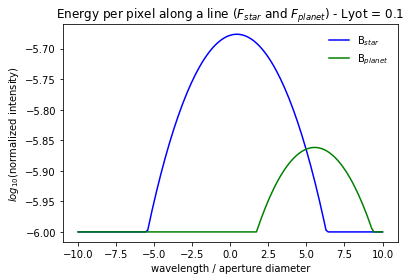

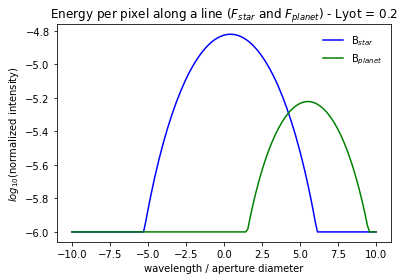

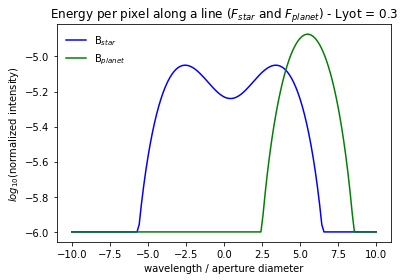

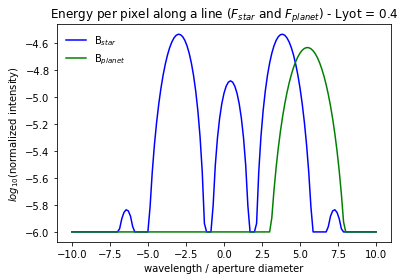

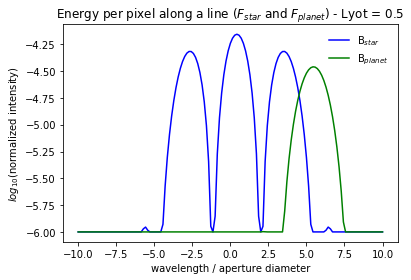

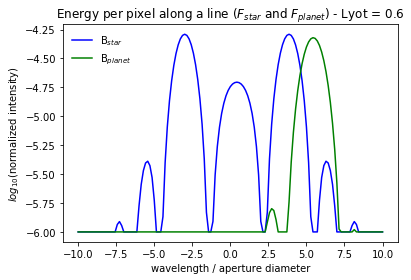

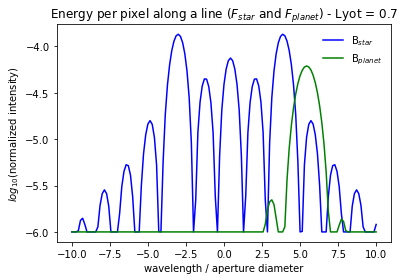

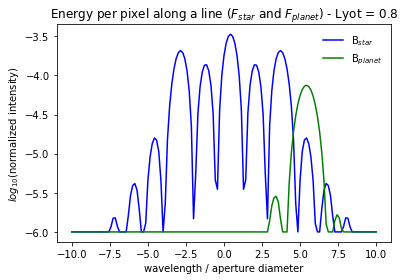

In [19]:
#To answer the question what are the problems found with small values of the Lyot stop.

#The main problem as can be seen in the plots is that the star's Airy ring where the planet is locates at is
#quite broad which in some way makes the planet fainter and diminishes the contrast.

#The smaller the Lyot stop, the broader the central peak. When the value is too small the dominant 
#Airy ring is the central one and overlaps the main Airy ring of the planet. However, increasing the Lyot stop
#makes the planet brighter and overlaps higher order rings of the star, which are less bright than the central peak. 

Lyot = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for i in range(len(Lyot)):
    N_lyot = padcplx(circle_mask(np.zeros((dtel, dtel)), xc, yc, Lyot[i] *xc), pad = nsamp)

    B_star, C_star, D_star, E_star, F_star = coro(A_star, M_lyot, N_lyot, 1)
    B_planet, C_planet, D_planet, E_planet, F_planet = coro(A_planet, M_lyot, N_lyot, 1)

    F_planet    = F_planet / np.sqrt(Isum(F_planet)) * np.sqrt(Norm_planet) #Normalizing F_star and F_planet to compare
    F_star      = F_star / (dtel * nsamp)

#nsamp = 7.
    plt.figure()
    plt.plot( Center, logit(xaxis_energy(F_star, 10 * nsamp)), c  = 'b', linewidth = 1.5, label = r'B$_{star}$' )
    plt.plot( Center, logit(xaxis_energy(F_planet, 10 * nsamp)), c  = 'g', linewidth = 1.5, label = r'B$_{planet}$' )
    plt.title(r'Energy per pixel along a line ($F_{star}$ and $F_{planet}$) - Lyot = %1.1f'%Lyot[i])
    plt.xlabel('wavelength / aperture diameter')
    plt.ylabel(r'$log_{10}$(normalized intensity)')
    plt.legend(frameon = False, loc = 'best')